# Population Modelling

Model: a collection of elements designed in order to understand and simulate how complex systems works. Models which do not belong to the Big Data regime, are designed so that to gain insights of how certain variables affect an outcome

That all models are wrong, but some are useful
-- George Box

In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [357]:
class Person:
    def __init__(self, situation, position, speed, extremes):
        self.situation, self.position = situation, position
        self.speed, self.extremes = speed, extremes
        angle = np.random.uniform(0, 2*np.pi)
        self.x_dir, self.y_dir = np.cos(angle), np.sin(angle)
        self.reabilitation = 0
        
    def step_ahead(self, community, proximity, contagiousness, rand_move=False):
        self = contacts(self, community, proximity, contagiousness)
        self = new_pos(self, rand_move)

In [358]:
def contacts(ind, community, proximity, unlikelyness_of_contact):
    if ind.situation == 2:
        pass
    elif ind.situation == 1:
        ind.reabilitation += 1
        if ind.reabilitation >= 14:
            ind.situation = 2
    else:
        close_people = 0
        for friend in community:
            xx = (ind.position[0]-friend.position[0])
            yy = (ind.position[1]-friend.position[1])
            if (friend.situation == 1) and ((np.sqrt(xx**2 + yy**2) < proximity)):
                close_people += 1
        if sum([1 for x in np.random.random(close_people) if x >unlikelyness_of_contact]) > 0:
            ind.situation = 1
    return ind

def check_bounds(ind, x_or_y, travelled_dist, i, rand_move):
    if ind.position[i] + x_or_y*travelled_dist < 0:
        updated_pos = -ind.position[i] + (-x_or_y*travelled_dist)
        updated_dir = -x_or_y 
    elif ind.position[i] + ind.x_dir*travelled_dist > ind.extremes[i]:
        updated_pos = -ind.position[i] + (-x_or_y*travelled_dist) + 2*ind.extremes[i]
        updated_dir = -x_or_y
    else:
        updated_pos = ind.position[i] + x_or_y*travelled_dist
        if rand_move:
            updated_dir = np.random.uniform(-1, 1) 
        else:    
            updated_dir = x_or_y
    return updated_pos, updated_dir

def new_pos(ind, rand_move):
    travelled_dist = ind.speed*np.random.random()
    ind.position[0], ind.x_dir = check_bounds(ind, ind.x_dir, travelled_dist, 0, rand_move)
    ind.position[1], ind.y_dir = check_bounds(ind, ind.y_dir, travelled_dist, 1, rand_move)
    return ind

In [367]:
def pop_simulation(size, iterations, probs_positives, 
                   grid_limits, min_contact_radious, 
                   unlikelyness_of_spread, chaotic=False):
    population = []
    for i in range(0, size):
        population.append(Person(np.random.choice(2, 1, p=[1-probs_positives, probs_positives])[0], 
                                [random.randrange(grid_limits[0]), random.randrange(grid_limits[1])],
                                random.uniform(0, 1), grid_limits))

    negatives, positives, survivors = [], [], []
    x_res, y_res, state = [], [], []
    index = []
    for it in range(iterations):
        it_negative, it_positives, it_survivors = 0, 0, 0
        for i, single in enumerate(population):
            x_res.append(single.position[0])
            y_res.append(single.position[1])
            index.append(it)
            if single.situation == 0:
                it_negative += 1
                state.append('Susceptible')
            elif single.situation == 1:
                it_positives += 1
                state.append('Infected')
            else:
                it_survivors += 1
                state.append('Recovered')
            single.step_ahead(population[:i]+population[i+1:], min_contact_radious, 
                              unlikelyness_of_spread, rand_move=chaotic)
        negatives.append(it_negative)
        positives.append(it_positives)
        survivors.append(it_survivors)
    return negatives, positives, survivors, x_res, y_res, state, index

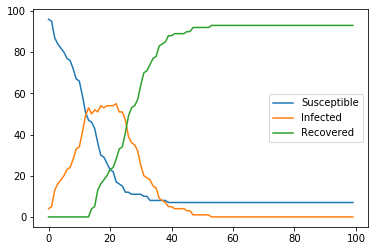

In [406]:
probs_positives = 0.04
grid_limits = [2, 2]
min_contact_radious = 0.2
unlikelyness_of_spread = 0.95
iterations = 100
size = 100
chaotic = True
negatives, positives, survivors, x_res, y_res, state, index = pop_simulation(size, iterations, 
                                                                             probs_positives, 
                                                                             grid_limits, 
                                                                             min_contact_radious, 
                                                                             unlikelyness_of_spread, 
                                                                             chaotic)
plt.plot(negatives, label='Susceptible')
plt.plot(positives, label='Infected')
plt.plot(survivors, label='Recovered')
plt.legend()
plt.show()

In [407]:
d = {'x_pos': x_res, 'y_pos': y_res, 'state': state, 'index':index}
df = pd.DataFrame(data=d)
df.head()

,x_pos,y_pos,state,index
0,1.0,1.0,Susceptible,0
1,1.0,0.0,Susceptible,0
2,1.0,0.0,Susceptible,0
3,0.0,1.0,Susceptible,0
4,0.0,0.0,Susceptible,0


In [408]:
for i in list(df['index'].unique()):
    for j in list(df['state'].unique()):
        if len(df[(df['index']==i) & (df['state'] == j)]) == 0:
            df = df.append(pd.DataFrame([[grid_limits[0]+5, grid_limits[1]+5, j, i]], 
                                        columns=df.columns))

In [441]:
def replay_plot(negatives, positives, survivors, df):
    fig = make_subplots(rows=2, cols=1)

    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=negatives,
                         mode="lines",
                         line=dict(width=2, color="blue"), name='Susceptible',),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=positives,
                         mode="lines",
                         line=dict(width=2, color="green"), name='Infected',),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(x=[i for i in range(len(negatives))], y=survivors,
                         mode="lines",
                         line=dict(width=2, color="orange"), name='Recovered',),
        row=1, col=1
    )

    fig.add_trace(
        go.Scatter(
        x=df[(df['index']==len(df['index'].unique())-1) & (df['state']=='Susceptible')]['x_pos'], 
        y=df[(df['index']==len(df['index'].unique())-1) & (df['state']=='Susceptible')]['y_pos'],
        name='Susceptible',
        mode='markers',
        marker=dict(
        color="blue"),
        showlegend=False
        ),
        row=2, col=1)

    fig.add_trace(go.Scatter(
        x=df[(df['index']==len(df['index'].unique())-1) & (df['state']=='Infected')]['x_pos'], 
        y=df[(df['index']==len(df['index'].unique())-1) & (df['state']=='Infected')]['y_pos'],
        name='Infected',
        mode='markers',
        marker=dict(
        color="green"),
        showlegend=False
        ),
        row=2, col=1)

    fig.add_trace(go.Scatter(
        x=df[(df['index']==len(df['index'].unique())-1) & (df['state']=='Recovered')]['x_pos'], 
        y=df[(df['index']==len(df['index'].unique())-1) & (df['state']=='Recovered')]['y_pos'],
        name='Recovered',
        mode='markers',
        marker=dict(
        color="orange"),
        showlegend=False
        ),
        row=2, col=1)

    frames =[go.Frame(
            data=[go.Scatter(
                x=[i for i in range(k)],
                y=negatives,
                mode="lines",
                line=dict(width=2, color="blue")),
                 go.Scatter(
                x=[i for i in range(k)],
                y=positives,
                mode="lines",
                line=dict(width=2, color="green")),
                 go.Scatter(
                x=[i for i in range(k)],
                y=survivors,
                mode="lines",
                line=dict(width=2, color="orange")),
                go.Scatter(
                    x=df[(df['index']==k) & (df['state']=='Susceptible')]['x_pos'], 
                    y=df[(df['index']==k) & (df['state']=='Susceptible')]['y_pos'],
                    mode='markers',
                    marker=dict(
                    color="blue")
                    ),
                go.Scatter(
                    x=df[(df['index']==k) & (df['state']=='Infected')]['x_pos'], 
                    y=df[(df['index']==k) & (df['state']=='Infected')]['y_pos'],
                    mode='markers',
                    marker=dict(
                    color="green")
                    ),
                go.Scatter(
                    x=df[(df['index']==k) & (df['state']=='Recovered')]['x_pos'], 
                    y=df[(df['index']==k) & (df['state']=='Recovered')]['y_pos'],
                    mode='markers',
                    marker=dict(
                    color="orange")
                    ),
                ],
                traces=[0,1,2,3,4,5])

            for k in range(len(negatives))] 

    fig.frames=frames
    fig.update_layout(updatemenus= [
                {
                    "buttons": [
                        {
                            "args": [None, {"frame": {"duration": 100, "redraw": False},
                                            "fromcurrent": True, 
                                            "transition": {"duration": 10,
                                                           "easing": "quadratic-in-out"}}],
                            "label": "Play",
                            "method": "animate"
                        },
                        {
                            "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                              "mode": "immediate",
                                              "transition": {"duration": 0}}],
                            "label": "Pause",
                            "method": "animate"
                        }
                    ],
                    "direction": "left",
                    "pad": {"r": 10, "t": 87},
                    "showactive": False,
                    "type": "buttons",
                    "x": 0.14,
                    "xanchor": "right",
                    "y": 1.4,
                    "yanchor": "top"
                }
            ],)

    fig.update_xaxes(title_text="Simulation Steps", row=1, col=1)
    fig.update_yaxes(title_text="Number of Cases", row=1, col=1)
    fig.update_xaxes(title_text="X", range=[0,grid_limits[0]], row=2, col=1)
    fig.update_yaxes(title_text="Y", range=[0,grid_limits[1]], row=2, col=1)
    fig.update_layout(height=600, width=800, title_text="Interactive Simulation Modelling")
    fig.show()

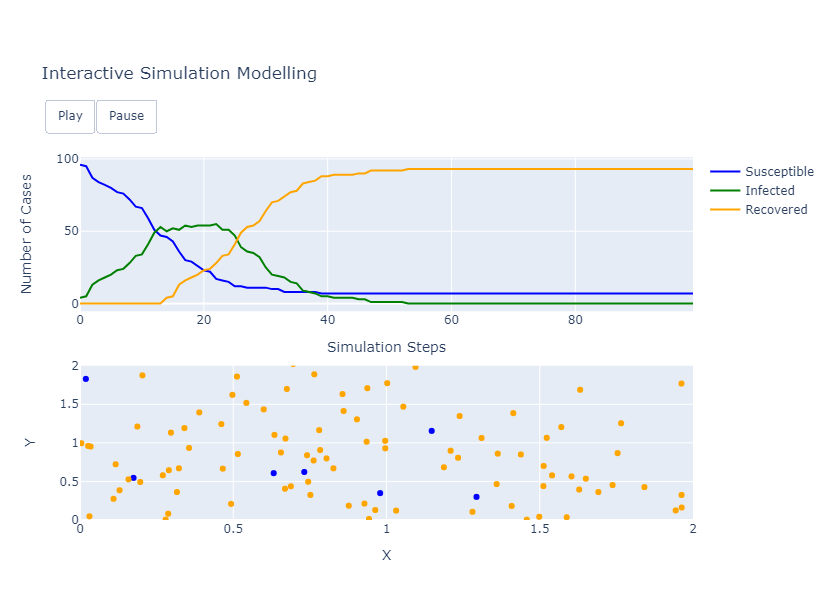

In [442]:
replay_plot(negatives, positives, survivors, df)

### Extra

In [16]:
# fig = go.FigureWidget()
# fig.add_scatter()
# fig

In [15]:
# for i in range(len(negatives)):
#     #time.sleep(0.3)
#     fig.data[0].y = negatives[:i] 

In [9]:
# import plotly.graph_objects as go

# # Create figure
# fig = go.Figure(
#     data=[go.Scatter(x=[i for i in range(len(negatives))], y=negatives,
#                      mode="lines",
#                      line=dict(width=2, color="blue")),
#           go.Scatter(x=[i for i in range(len(negatives))], y=positives,
#                      mode="lines",
#                      line=dict(width=2, color="green")),
#          go.Scatter(x=[i for i in range(len(negatives))], y=survivors,
#                      mode="lines",
#                      line=dict(width=2, color="orange"))],
#         layout=go.Layout(
#         xaxis=dict(range=[0,100], autorange=False, zeroline=False),
#         yaxis=dict(range=[0,200], autorange=False, zeroline=False),
#         title_text="Kinematic Generation of a Planar Curve", hovermode="closest",
#         updatemenus= [
#             {
#                 "buttons": [
#                     {
#                         "args": [None, {"frame": {"duration": 500, "redraw": False},
#                                         "fromcurrent": True, "transition": {"duration": 300,
#                                                                             "easing": "quadratic-in-out"}}],
#                         "label": "Play",
#                         "method": "animate"
#                     },
#                     {
#                         "args": [[None], {"frame": {"duration": 0, "redraw": False},
#                                           "mode": "immediate",
#                                           "transition": {"duration": 0}}],
#                         "label": "Pause",
#                         "method": "animate"
#                     }
#                 ],
#                 "direction": "left",
#                 "pad": {"r": 10, "t": 87},
#                 "showactive": False,
#                 "type": "buttons",
#                 "x": 0.1,
#                 "xanchor": "right",
#                 "y": 0,
#                 "yanchor": "top"
#             }
#         ]),

#     frames=[go.Frame(
#         data=[go.Scatter(
#             x=[i for i in range(k)],
#             y=negatives,
#             mode="lines",
#             line=dict(width=2, color="blue")),
#              go.Scatter(
#             x=[i for i in range(k)],
#             y=positives,
#             mode="lines",
#             line=dict(width=2, color="green")),
#              go.Scatter(
#             x=[i for i in range(k)],
#             y=survivors,
#             mode="lines",
#             line=dict(width=2, color="orange"))])

#         for k in range(len(negatives))],
    
# )

# fig.show()

In [10]:
# index[::-1][0]

In [11]:
# df[(df['index']==0) & (df['state']=='Recovered')]#['x_pos']

In [12]:
# fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=df[df['index']==0][df['state']=='Susceptible']['x_pos'], y=df[df['index']==0][df['state']=='Susceptible']['y_pos'],
#     name='0',
#     mode='markers',
# ))

# fig.add_trace(go.Scatter(
#     x=df[df['index']==0][df['state']=='Infected']['x_pos'], y=df[df['index']==0][df['state']=='Infected']['y_pos'],
#     name='1',
#     mode='markers',
# ))

# fig.add_trace(go.Scatter(
#     x=df[df['index']==0][df['state']=='Recovered']['x_pos'], y=df[df['index']==1][df['state']=='Recovered']['x_pos'],
#     name='2',
#     mode='markers',
# ))

# fig.show()

In [13]:
# fig = px.scatter(df, x="x_pos", y="y_pos", color="state", 
#                  animation_frame="index",
#                  range_x=[0,grid_limits[0]], range_y=[0,grid_limits[1]])
# fig

In [14]:
# space = np.linspace(size, size*iterations, iterations)
# for i, num in enumerate(space[1:]):
#     plt.scatter(x_res[int(space[i]):int(num)], y_res[int(space[i]):int(num)], 
#                 c=state[int(space[i]):int(num)])
#     plt.show()

In [15]:
# go.Figure(
#     data=[go.Scatter(x=[i for i in range(len(negatives))], y=negatives,
#                      mode="lines",
#                      line=dict(width=2, color="blue")),
#           go.Scatter(x=[i for i in range(len(negatives))], y=positives,
#                      mode="lines",
#                      line=dict(width=2, color="green")),
#          go.Scatter(x=[i for i in range(len(negatives))], y=survivors,
#                      mode="lines",
#                      line=dict(width=2, color="orange"))],
#         layout=go.Layout(
#         xaxis=dict(range=[0,100], autorange=False, zeroline=False),
#         yaxis=dict(range=[0,200], autorange=False, zeroline=False),
#         title_text="Kinematic Generation of a Planar Curve", hovermode="closest",
#         updatemenus= [
#             {
#                 "buttons": [
#                     {
#                         "args": [None, {"frame": {"duration": 500, "redraw": False},
#                                         "fromcurrent": True, "transition": {"duration": 300,
#                                                                             "easing": "quadratic-in-out"}}],
#                         "label": "Play",
#                         "method": "animate"
#                     },
#                     {
#                         "args": [[None], {"frame": {"duration": 0, "redraw": False},
#                                           "mode": "immediate",
#                                           "transition": {"duration": 0}}],
#                         "label": "Pause",
#                         "method": "animate"
#                     }
#                 ],
#                 "direction": "left",
#                 "pad": {"r": 10, "t": 87},
#                 "showactive": False,
#                 "type": "buttons",
#                 "x": 0.1,
#                 "xanchor": "right",
#                 "y": 0,
#                 "yanchor": "top"
#             }
#         ]),

#     frames=[go.Frame(
#         data=[go.Scatter(
#             x=[i for i in range(k)],
#             y=negatives,
#             mode="lines",
#             line=dict(width=2, color="blue")),
#              go.Scatter(
#             x=[i for i in range(k)],
#             y=positives,
#             mode="lines",
#             line=dict(width=2, color="green")),
#              go.Scatter(
#             x=[i for i in range(k)],
#             y=survivors,
#             mode="lines",
#             line=dict(width=2, color="orange"))])

#         for k in range(len(negatives))],
    
# )

In [16]:
# len(negatives), len(df['index'].unique())

In [17]:
# import plotly.graph_objects as go
# import numpy as np
# from plotly.subplots import make_subplots

# fig = make_subplots(
#     rows=1, cols=2, subplot_titles=('Title1', 'Title2'),
#     horizontal_spacing=0.051
# )

# fig.add_trace(go.Bar(x=['A', 'B', 'C', 'D'], y=[4, 2, 1, 5]), row=1, col=1) #this is the trace of index 0
# fig.add_trace(go.Scatter(x=['A', 'B', 'C', 'D'], y=[2, 1.45, 0.25, 2.1],
#                         line_width=3), row=1, col=1)   # trace of index 1

# fig.add_trace(go.Scatter(x=np.arange(10),
#                          y=1+3*np.random.rand(10),
#                         marker_size=6), row=1, col=2)  #trace of index 2


# #traces=[0, 1, 2]` in the frame definition makes the difference: it tells that 
# #the traces of index 0, 1 from the subplot(1,1), are unchanged, and we only ensure their visibility in each #frame (because neither x nor y are modified)
# #while the trace 2 from the subplot(1,2) is animated, because the y-values are changed. 

# frames =[go.Frame(data=[go.Bar(visible=True),
#                         go.Scatter(visible=True),
#                         go.Scatter(y=2+3*np.random.rand(10))],
#                   traces=[0,1,2]) for k in range(20)]   # define 20 frames

# fig.frames=frames
# button = dict(
#              label='Play',
#              method='animate',
#              args=[None, dict(frame=dict(duration=50, redraw=False), 
#                               transition=dict(duration=0),
#                               fromcurrent=True,
#                               mode='immediate')])
# fig.update_layout(updatemenus=[dict(type='buttons',
#                               showactive=False,
#                               y=0,
#                               x=1.05,
#                               xanchor='left',
#                               yanchor='bottom',
#                               buttons=[button] )
#                                       ],
#                  width=800, height=500)
                              
# fig.update_layout(yaxis2_range=[0, 5.5], yaxis2_autorange=False)